In [4]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)

2.5.0


In [5]:
path = 'Dataset3/'
x1_train = pd.read_csv(path+'data_trainmid_x1.csv')
x2_train = pd.read_csv(path+'data_trainmid_x2.csv')
f1_train = pd.read_csv(path+'data_trainmid_f1.csv')
f1_test = pd.read_csv(path+'data_testmid_f1.csv')
x1_test = pd.read_csv(path+'data_testmid_x1.csv')
x2_test = pd.read_csv(path+'data_testmid_x2.csv')
print(len(x1_train),len(x1_test),len(f1_train),len(f1_test))
X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train),axis=1),columns = ['p1','p2'])
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test),axis=1),columns = ['p1','p2'])
X_train.head()

112459 62211 112459 62211


,p1,p2
0,-0.0000,-0.0000
1,-0.0159,-0.0000
2,-0.0159,0.0171
3,-0.0159,0.0171
4,-0.0000,0.0329


In [10]:
def get_results(t,m):
    l1 = len(X_train)
    l2 = len(X_test)
    x_train = [[0 for _ in range(m*2)] for _ in range(l1-t*(m-1))]
    x_test = [[0 for _ in range(m*2)] for _ in range(l2-t*(m-1))]

    for i in range(l1-t*(m-1)):
        for j in range(m):
            x_train[i][j]=X_train.iloc[t*(m-1)+i-2*j,0]
            x_train[i][j+m]=X_train.iloc[t*(m-1)+i-2*j,1]

    y_train = f1_train.iloc[t*(m-1):]

    for i in range(l2-t*(m-1)):
        for j in range(m):
            x_test[i][j]=X_test.iloc[t*(m-1)+i-2*j,0]
            x_test[i][j+m]=X_test.iloc[t*(m-1)+i-2*j,1]
    y_test = f1_test.iloc[t*(m-1):]
    x_train,x_test = np.array(x_train),np.array(x_test)
    
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    
    importances = rf.feature_importances_
    plt.figure(figsize=(20,5))
    x_plot = ['x1(n{})'.format(-i) for i in range(0,m*t,t)] + ['x2(n{})'.format(-i) for i in range(0,m*t,t)]
    plt.plot(x_plot,importances, label = 'Importance Plot')
    plt.legend()
    plt.xlabel('Feature')
    plt.ylabel('Feature importance')
    plt.title('Importance plot for random forest')
    plt.show()
    
    # RBF MODEL
    t1 = datetime.now()
    clf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))
    clf.fit(x_train,y_train)
    t2 = datetime.now()

    print('Time taken by RBF Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y2 = y1_pred
    print('Root mean square error: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    # Deep Learning Model
    inp = Input((m*2))
    x = Dense(9,activation = 'relu')(inp)
    x = Dense(12,activation = 'relu')(x)
    x = Dense(1)(x)

    model = Model(inputs = inp, outputs = x)
    model.compile(optimizer = 'adam', loss = 'mse')
    t3 = datetime.now()
    his = model.fit(x_train,y_train, epochs=15)
    t4 = datetime.now()
    print('Time taken by Deep Learning Model',t4-t3)
    y1_pred = model.predict(x_test)
    y3 = y1_pred
    print('Root mean squared error:',sqrt(mean_squared_error(y_test,y1_pred)))
    error2 = []
    for i in range(len(y_test)):
        error2.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error2))
    print('Maximum Error =',max(error2))
    error3 = sorted(error2)
    print('Median Value of Error =',error3[len(error)//2])
    
    # COMPARISON
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF')
    plt.plot(list(range(6000)),y3[:6000], label = 'Deep Learning')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    
    plt.plot(list(range(len(y1_pred))),error, label = 'Error of Random Forest')
    plt.plot(list(range(len(y1_pred))),error2, label = 'Error of Deep Learning')
    plt.plot(list(range(len(y1_pred))),error5, label = 'Error of RBF Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error2[:6000], label = 'Deep Learning model')
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()

Time taken by Random Forest 0:02:20.816013
Root Mean Squared error of Random Forest 0.06009451463656044
Minimum Error = 1.3877787807814457e-17
Maximum Error = 0.8900700000000008
Median Value of Error = 0.018882999999999872


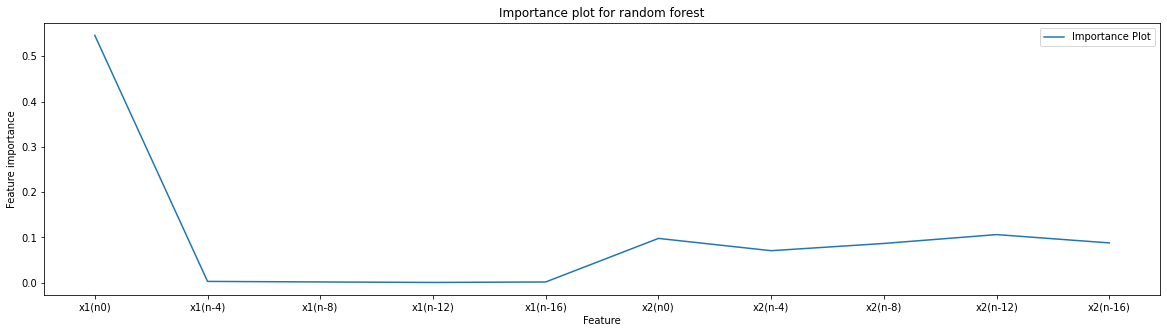

Time taken by RBF Model:  0:00:50.442026
Root mean square error:  0.050940471940941506
Minimum Error = 3.9158457462717955e-07
Maximum Error = 0.6906620971175628
Median Value of Error = 0.030688509077194226
Epoch 1/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0666
Epoch 2/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0187
Epoch 3/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0131
Epoch 4/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0108
Epoch 5/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0093
Epoch 6/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0080
Epoch 7/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0071
Epoch 8/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0067
Epoch 9/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0060
Epoch 10/15
3514/3514 [========================

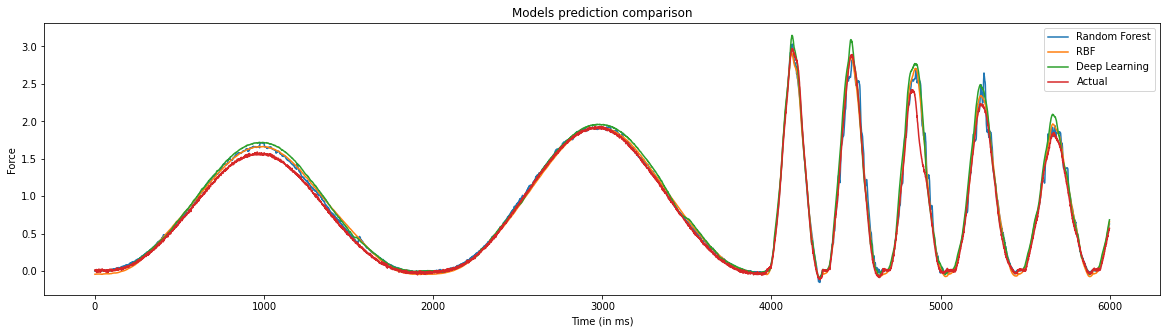

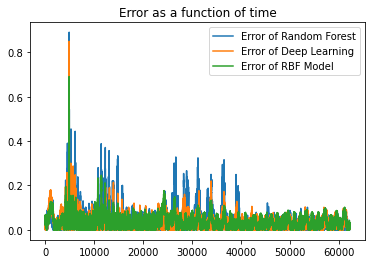

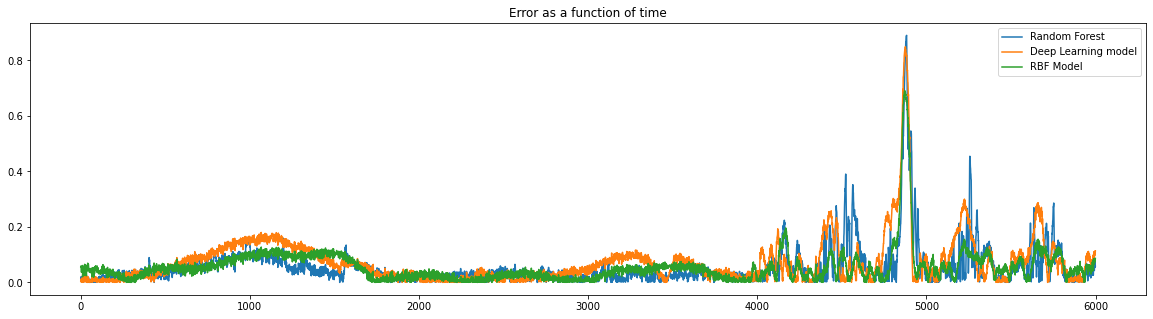

In [11]:
get_results(t=4, m=5)

Time taken by Random Forest 0:01:26.352290
Root Mean Squared error of Random Forest 0.05981540152685
Minimum Error = 9.999999999177334e-07
Maximum Error = 0.9079140000000019
Median Value of Error = 0.01901900000000012


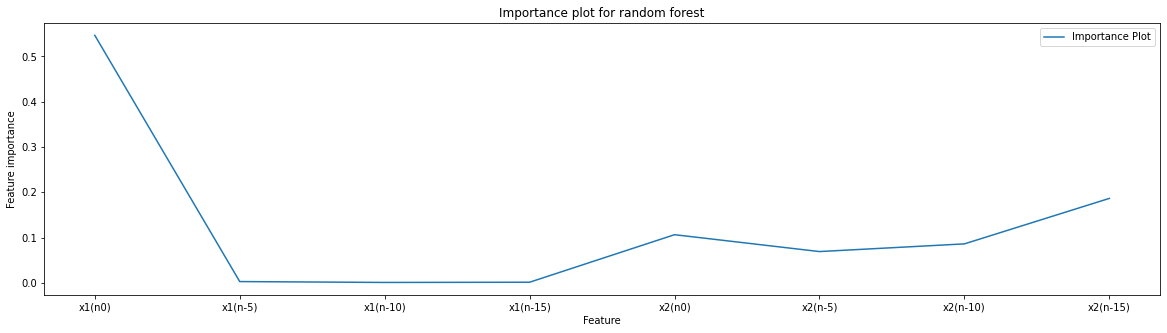

Time taken by RBF Model:  0:00:41.360389
Root mean square error:  0.05117346910913883
Minimum Error = 8.253560696003248e-08
Maximum Error = 0.6861654873409748
Median Value of Error = 0.031181780673790738
Epoch 1/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0633
Epoch 2/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0174
Epoch 3/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0138
Epoch 4/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0120
Epoch 5/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0105
Epoch 6/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0098
Epoch 7/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0090
Epoch 8/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0082
Epoch 9/15
3514/3514 [==============================] - 4s 1ms/step - loss: 0.0077
Epoch 10/15
3514/3514 [==========================

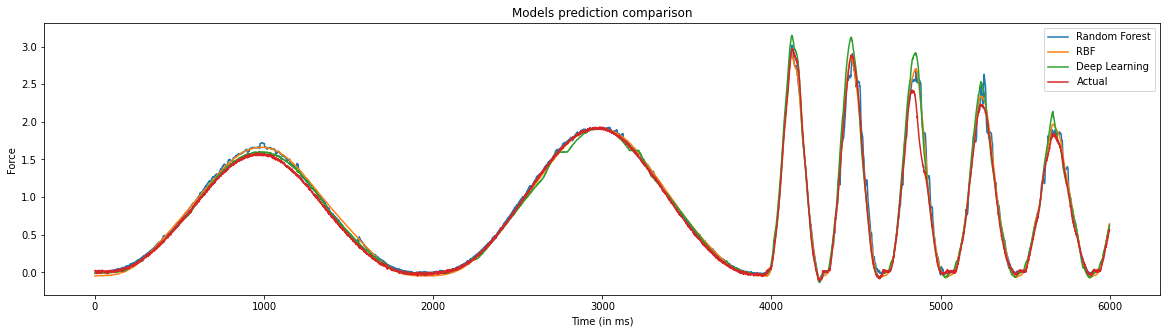

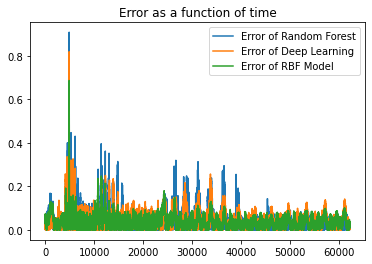

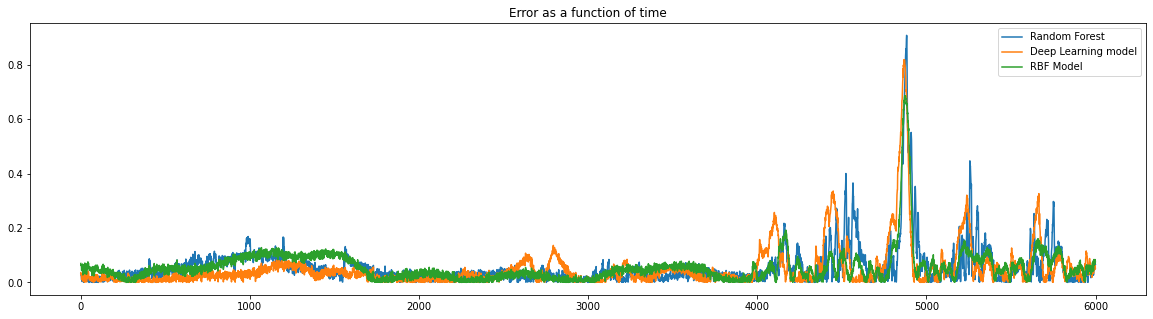

In [12]:
get_results(t=5, m=4)